Fetching data...
Building model...
Training model...
Epoch 1/10
40/40 [==============================] - 1s 17ms/step - loss: 2.0735 - accuracy: 0.1484 - val_loss: 2.0623 - val_accuracy: 0.1781
Epoch 2/10
40/40 [==============================] - 0s 11ms/step - loss: 2.0354 - accuracy: 0.3320 - val_loss: 2.0180 - val_accuracy: 0.3313
Epoch 3/10
40/40 [==============================] - 0s 12ms/step - loss: 1.9352 - accuracy: 0.6125 - val_loss: 1.9062 - val_accuracy: 0.5156
Epoch 4/10
40/40 [==============================] - 0s 11ms/step - loss: 1.7069 - accuracy: 0.8133 - val_loss: 1.6663 - val_accuracy: 0.7312
Epoch 5/10
40/40 [==============================] - 0s 11ms/step - loss: 1.3148 - accuracy: 0.9156 - val_loss: 1.3109 - val_accuracy: 0.8719
Epoch 6/10
40/40 [==============================] - 0s 11ms/step - loss: 0.8638 - accuracy: 0.9586 - val_loss: 0.9745 - val_accuracy: 0.8938
Epoch 7/10
40/40 [==============================] - 0s 11ms/step - loss: 0.5145 - accuracy: 0.9711 - 

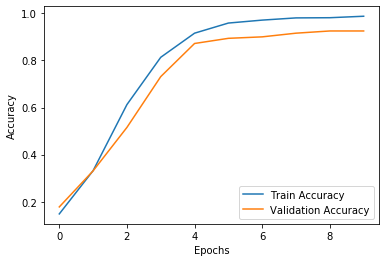

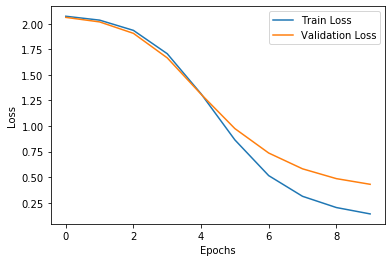

10/10 [==============================] - 0s 2ms/step


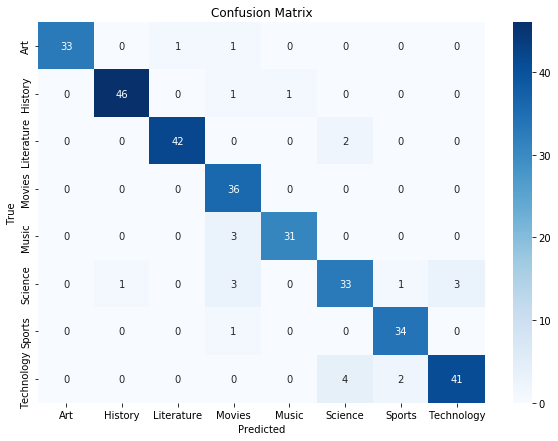

In [2]:
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# 1. Função para coletar artigos da API da Wikipédia
def fetch_wikipedia_articles(categories, num_articles=100):
    articles = []
    base_url = "https://en.wikipedia.org/w/api.php"
    for category in categories:
        params = {
            "action": "query",
            "format": "json",
            "list": "search",
            "srsearch": category,
            "srlimit": num_articles,  # Aumentando a quantidade de artigos
        }
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            for result in data['query']['search']:
                articles.append({
                    "title": result["title"],
                    "text": result["snippet"],  # Usando o snippet do artigo para simplificação
                    "category": category
                })
    return pd.DataFrame(articles)

# 2. Pré-processamento de texto
def preprocess_text(text):
    # Remove HTML tags, caracteres especiais, pontuação, etc.
    text = tf.keras.preprocessing.text.text_to_word_sequence(text)
    return " ".join(text)

# 3. Construção do modelo
def build_model(vocab_size, max_length, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 4. Pipeline principal
def main():
    # Categorias para buscar (assuntos + gêneros)
    categories = ["Science", "History", "Technology", "Art", "Sports", "Literature", "Movies", "Music"]
    
    # Coleta de dados
    print("Fetching data...")
    articles = fetch_wikipedia_articles(categories, num_articles=200)  # Aumentando para 200 artigos por categoria
    articles['text'] = articles['text'].apply(preprocess_text)
    
    # Codificação das categorias
    label_encoder = LabelEncoder()
    articles['category_encoded'] = label_encoder.fit_transform(articles['category'])
    
    # Tokenização e vetorização
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(articles['text'])
    sequences = tokenizer.texts_to_sequences(articles['text'])
    vocab_size = len(tokenizer.word_index) + 1
    max_length = max(len(seq) for seq in sequences)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    
    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        padded_sequences, articles['category_encoded'], test_size=0.2, random_state=42
    )
    
    # Construção do modelo
    print("Building model...")
    model = build_model(vocab_size, max_length, len(categories))
    
    # Treinamento do modelo
    print("Training model...")
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    
    # Avaliação do modelo
    print("Evaluating model...")
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    
    # Contagem de artigos classificados por categoria
    print("\nQuantidades de artigos classificados por categoria:")
    true_categories = label_encoder.inverse_transform(y_test)
    predicted_categories = label_encoder.inverse_transform(y_pred)
    
    # Criar um dicionário para armazenar as quantidades de artigos por categoria
    category_counts = {category: {"True": 0, "Predicted": 0} for category in categories}
    
    # Contar as ocorrências
    for true_cat, pred_cat in zip(true_categories, predicted_categories):
        category_counts[true_cat]["True"] += 1
        if true_cat == pred_cat:
            category_counts[pred_cat]["Predicted"] += 1
    
    # Imprimir as quantidades de artigos classificados corretamente
    for category in categories:
        print(f"{category}:")
        print(f"  Verdadeiros: {category_counts[category]['True']}")
        print(f"  Corretos: {category_counts[category]['Predicted']}")
    
    # Contagem total de artigos por categoria no conjunto de dados
    print("\nQuantidade total de artigos por categoria no conjunto de teste:")
    total_categories = {category: 0 for category in categories}
    for category in true_categories:
        total_categories[category] += 1
    
    # Imprimir a quantidade total de artigos por categoria
    for category in categories:
        print(f"{category}: {total_categories[category]}")
    
    # Visualização dos resultados de acurácia
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Matriz de Confusão
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    
if __name__ == "__main__":
    main()